In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

In [3]:
path = '/content/lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

MPS device not found.


torch.Size([250, 250, 3])


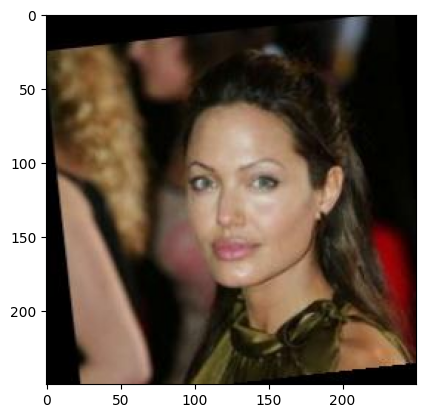

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

# 1. Applications

## AutoEncoder
Imagine you have a bunch of photos, and you want to shrink them down to save space while keeping the important features. Autoencoders help with this by learning how to compress the pictures and later reconstruct them.

## VAE
Now imagine you not only want to compress pictures but also want to generate new, similar pictures. VAEs not only learn how to compress but also how to create new variations.

# 2. Architecture

## AutoEncoder
AEs consist of an encoder that maps input data to a lower-dimensional latent space and a decoder that reconstructs the input from this latent representation.

## VAE
VAEs consist of an encoder and a decoder. However, VAEs introduce a probabilistic component in the form of a variational distribution in the latent space.
VAEs use a reparameterization trick during training to sample from the variational distribution, introducing stochasticity.

# 3. Loss Function

## AutoEncoder
The primary loss function is a measure of how well the reconstructed output matches the input data. Common choices include Mean Squared Error (MSE) loss.

## VAE
VAEs have two components in their loss function.
* Reconstruction Loss: Measures the fidelity of the generated samples to the input data.
* Regularization Term (Kullback-Leibler Divergence): Encourages the learned latent space to follow a specific probabilistic distribution (usually a unit Gaussian). This regularization term helps in improving the continuity of the latent space.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

Encoder Structure:

* An input image (x) is fed through a sequence of convolutional layers (nn.Conv2d) with ReLU activation functions by the encoder portion. The input's spatial dimensions are gradually shrunk by this encoder.
* After that, the encoder's output is flattened (view) in order to feed it into fully connected layers.

Latent Space Representation:

* The flattened output is passed through two fully connected layers to obtain the mean (mu) and log-variance (logvar) of the latent space. These values define a probabilistic distribution in the latent space.

Reparameterization Trick:

* The reparameterize function introduces randomness by sampling from a normal distribution (torch.randn_like(std)). This helps during training and is part of the "reparameterization trick" to make backpropagation possible.

Decoder Architecture:

* The sampled latent variable (z) is passed through a fully connected layer (fc_dec) to get it ready for the decoder. Then, it's reshaped to match the dimensions expected by the transpose convolutional layers in the decoder.

Forward Pass:

* The forward function orchestrates the entire process.
* It first encodes the input image to obtain mean and log-variance, samples a latent variable using the reparameterization trick, and then decodes this variable to generate a reconstructed image.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder Layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.relu4 = nn.ReLU()

        latent_size = 20

        # Fully connected layers for mean and log-variance
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_size)
        self.fc_logvar = nn.Linear(128 * 16 * 16, latent_size)

        # Fully connected layer for decoder
        self.fc_dec = nn.Linear(latent_size, 128 * 16 * 16)

        # Decoder Layers
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.relu5 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1)
        self.relu6 = nn.ReLU()
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1)
        self.relu7 = nn.ReLU()
        self.deconv4 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1)
        self.relu8 = nn.ReLU()
        self.deconv5 = nn.ConvTranspose2d(8, 3, kernel_size=4, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()

    def encoder(self, x):
        h = self.relu1(self.conv1(x))
        h = self.relu2(self.conv2(h))
        h = self.relu3(self.conv3(h))
        h = self.relu4(self.conv4(h))
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        z = self.fc_dec(z)
        z = z.view(z.size(0), 128, 16, 16)
        h = self.relu5(self.deconv1(z))
        h = self.relu6(self.deconv2(h))
        h = self.relu7(self.deconv3(h))
        h = self.relu8(self.deconv4(h))
        return self.sigmoid(self.deconv5(h))

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

## Explain how would you generate new samples in the latent space
* An instance of the VAE model is created.
* A batch of images is loaded and preprocessed. The first image from the batch is selected and moved to the same device as the model.
* The image is passed through the VAE's encode method to obtain the mean (mu) and log-variance (logvar) vectors in the latent space.
* The shapes of mu and logvar are printed for inspection.
* The reparameterize method is used to sample points in the latent space based on the mean and log-variance.
* The shape of the latent samples is printed.
* The decode method is used to generate new images from the sampled points in the latent space.
* The shape of the generated images is printed for inspection.

In [8]:
model = VAE()

# Initialize your DataLoader to get a batch of images
dataiter = iter(dataloader)
images, _ = dataiter.__next__()

if torch.cuda.is_available():
    model = model.cuda()
    images = images.cuda()

input_image = images[0].unsqueeze(0)

output, mu, logvar = model(input_image)

print("Shape of encoded output (mu and logvar):", mu.shape, logvar.shape )
print("Shape of decoded output:", output.shape)

Shape of encoded output (mu and logvar): torch.Size([1, 20]) torch.Size([1, 20])
Shape of decoded output: torch.Size([1, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [9]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 2252099


* create an optimizer for training

In [10]:
import torch.optim as optim

optim = torch.optim.Adam(model.parameters(), lr=0.001)

## Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves

In a Variational Autoencoder (VAE), the loss function is a combination of two terms: the reconstruction loss and the Kullback-Leibler (KL) divergence
* Reconstruction Loss
 This term measures how well the generated output matches the input data. It essentially quantifies the difference between the original and reconstructed images.
> The Binary Cross Entropy loss is commonly used for tasks where the input and output can be treated as binary values.
> It calculates the difference between each pixel's intensity in the original and reconstructed images.
* KL Divergence
  * Imagine you're trying to organize a party, and you want everyone to be evenly distributed across the room. In our case, the "party" is the latent space, and we want the "guests" (latent variables) to be spread out like a well-behaved crowd.
  *  KL divergence is like a party planner checking how evenly people are spread out. The plan is to compare how the guests are standing (latent variables' distribution) with an ideal arrangement (a standard Gaussian distribution).
  *  If the guests are all over the place, the party planner gives a penalty (negative sign in the formula) to encourage a more organized setup. The aim is to make the party (latent space) smoother and more predictable.

The combined loss function aims to strike a balance between accurately reconstructing input data and ensuring that the latent space follows a desirable distribution.

---



Ref: https://medium.com/@rushikesh.shende/autoencoders-variational-autoencoders-vae-and-%CE%B2-vae-ceba9998773d

In [11]:
def loss_function(recon_x, x, mean, log_var):

    # Reconstruction loss
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence
    kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return recon_loss + kl_div


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

## Troubleshooting loss

Latent size, changed from 128 to 20
* Effect: The model was overfitting earlier and hence the regenerated images very far from visible

Learning rate, changed from 0.0001 to 0.001
* Effect: The model was not showing a decreasing loss, rather it was stagnant. Decreasing the Learning Rate further showed a gradually decreasing loss

Loss function, changed from MSE to BCE
* Effect: The loss was less in MSE compared to BCE, but the regenerated images were far worse and not protrayed clearly. With BCE the loss is comparatively more, but the regenerated images are far better

Increasing model capacity
* Effect: Adding more layers lead to further increase in loss, though it was gradually decreasing, hence reverted back to my orginal model

Batch Normalization
* Effect: Adding batch normalization had way worse effect than any other changes I made, loss reached to around 10M.

In [13]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        optim.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optim.step()

        total_loss += loss.item()

    # Average loss for this epoch
    epoch_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}")

Epoch [1/10], Loss: 104064.210036262
Epoch [2/10], Loss: 98702.13884377124
Epoch [3/10], Loss: 98163.38096811966
Epoch [4/10], Loss: 97845.37805016243
Epoch [5/10], Loss: 97589.4113658684
Epoch [6/10], Loss: 97404.52804638514
Epoch [7/10], Loss: 97297.18475674247
Epoch [8/10], Loss: 97138.76138853215
Epoch [9/10], Loss: 97039.41483153282
Epoch [10/10], Loss: 96966.22506987989


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

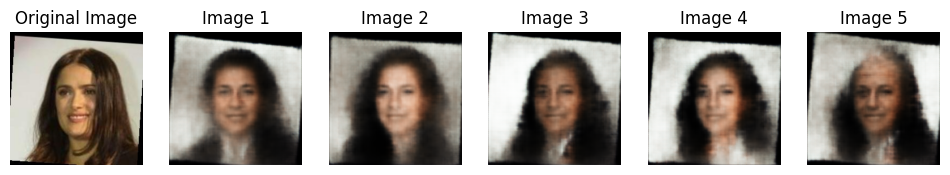

In [38]:
model.eval()

with torch.no_grad():
    data, _ = next(iter(dataloader))
    random_index = random.randint(0, data.size(0) - 1)
    original_image = data[random_index].unsqueeze(0).to(device)

    # Encode the image to get the latent space representation
    mu, logvar = model.encoder(original_image)

    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std

    # Plot the original image
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 6, 1)
    plt.imshow(original_image.cpu().squeeze().permute(1, 2, 0))
    plt.title("Original Image")
    plt.axis('off')

    for i in range(2, 7):
        # Introduce amplified variation
        z_varied = z + torch.randn_like(z) * 0.5

        # Decode the varied latent vector
        generated_image_varied = model.decoder(z_varied)

        # Plotting
        plt.subplot(2, 6, i)
        plt.imshow(generated_image_varied.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"Image {i-1}")
        plt.axis('off')

    plt.show()